In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
path = 'data/parquet/est_hourly.parquet'

df = pd.read_parquet(path).reset_index()[["Datetime", "AEP"]].rename(
    columns={"Datetime": "datetime", "AEP": "value"}
)
df = df.set_index("datetime")
df.head()

,value
datetime,
1998-12-31 01:00:00,NaN
1998-12-31 02:00:00,NaN
1998-12-31 03:00:00,NaN
1998-12-31 04:00:00,NaN
1998-12-31 05:00:00,NaN


In [5]:
#df = df[~df.value.isna()]
subsample = df.dropna()
subsample = subsample[subsample.index < "2006-01-01 00:00:00"]

In [6]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(subsample.value)

ADF Statistic: -5.896945
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Stationary


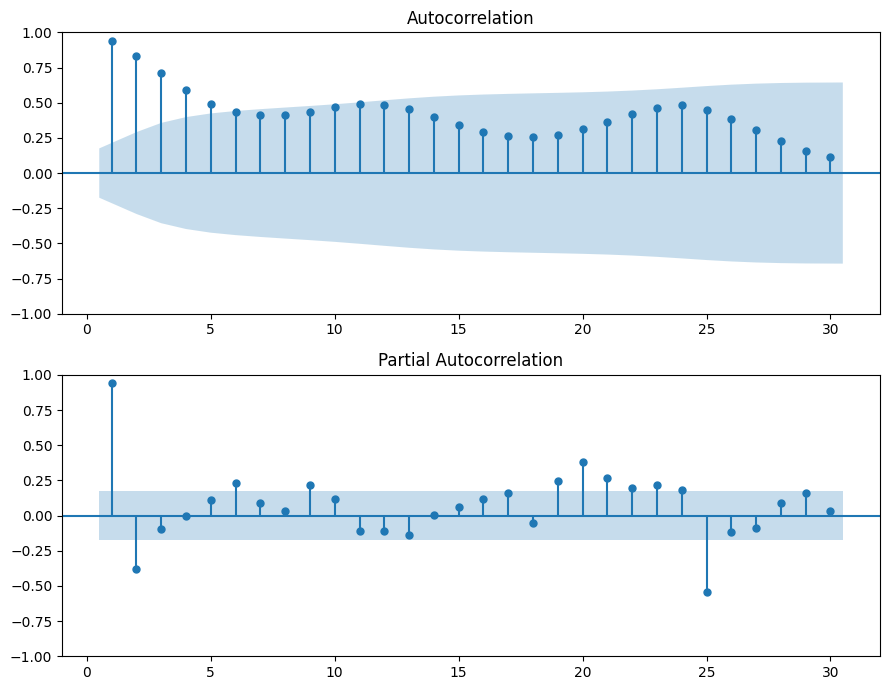

In [15]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(9, 7))
plot_acf(subsample.value[:125], lags=30, ax=ax[0], zero=False)
plot_pacf(subsample.value[:125], lags=30, ax=ax[1], method='ols', zero=False)


plt.tight_layout()
plt.show()

ACF (q): 4
PACF (p): 3
d: 1

In [19]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(subsample.value, order=(1,3,4))
model_fit = model.fit()
print(model_fit.summary())

p:\Poetry\virtualenvs\ncps-NEh_RkW9-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
p:\Poetry\virtualenvs\ncps-NEh_RkW9-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
p:\Poetry\virtualenvs\ncps-NEh_RkW9-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
p:\Poetry\virtualenvs\ncps-NEh_RkW9-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecas

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                10964
Model:                 ARIMA(1, 3, 4)   Log Likelihood              -84369.655
Date:                Fri, 16 Aug 2024   AIC                         168751.309
Time:                        20:56:40   BIC                         168795.122
Sample:                             0   HQIC                        168766.072
                              - 10964                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9637      0.014    -70.050      0.000      -0.991      -0.937
ma.L1         -0.1890      0.033     -5.808      0.000      -0.253      -0.125
ma.L2         -1.0716      0.032    -33.935      0.0

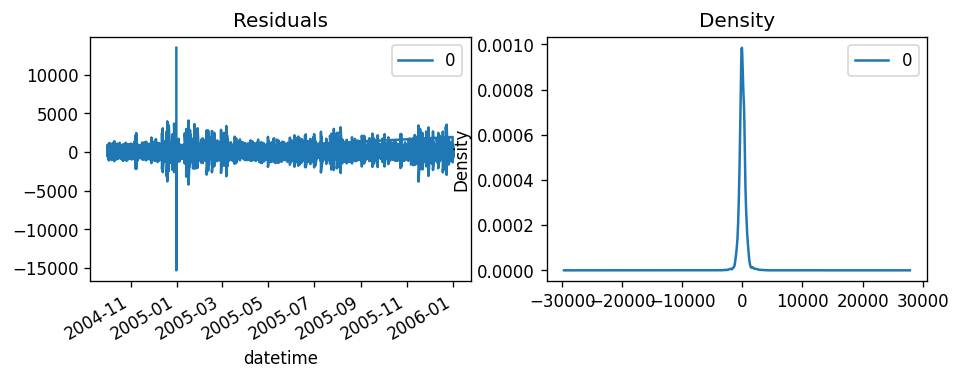

In [20]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

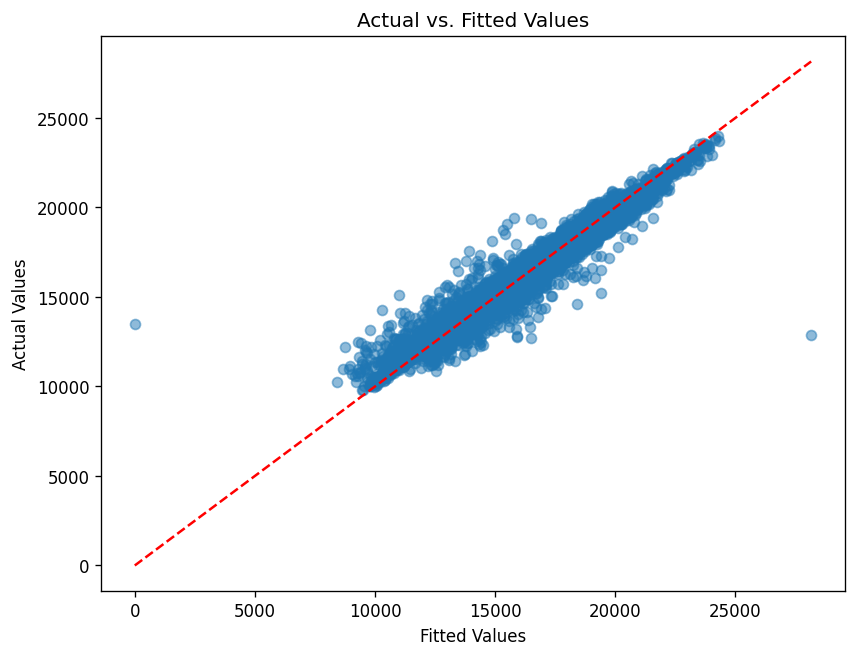

In [26]:
# Get the fitted values
fitted_values = model_fit.fittedvalues

# Plot actual vs. fitted
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, subsample.value, alpha=0.5)
plt.plot([min(fitted_values), max(fitted_values)], [min(fitted_values), max(fitted_values)], color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Fitted Values')
plt.show()